In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
import os
Dataset_path = "/content/drive/MyDrive/Colab Notebooks/golddataset.csv"
dataset_path = os.path.join(Dataset_path)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv(dataset_path)
df.head()

,Date,GC=F_Close,GC=F_High,GC=F_Low,GC=F_Open,GC=F_Volume
0,12/18/2000,269.700012,270.000000,269.700012,270.000000,17
1,12/19/2000,269.700012,269.700012,269.000000,269.700012,203
2,12/20/2000,272.500000,272.500000,272.000000,272.500000,5
3,12/21/2000,273.700012,273.700012,273.000000,273.000000,110
4,12/22/2000,273.700012,274.000000,273.700012,273.700012,13


In [6]:
df.dtypes

,0
Date,object
GC=F_Close,float64
GC=F_High,float64
GC=F_Low,float64
GC=F_Open,float64
GC=F_Volume,int64


In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.describe()

,Date,GC=F_Close,GC=F_High,GC=F_Low,GC=F_Open,GC=F_Volume
count,6273,6273.000000,6273.000000,6273.000000,6273.000000,6273.000000
mean,2013-06-25 22:55:02.152080384,1258.363526,1264.838913,1251.593193,1258.269281,4334.104735
min,2000-12-18 00:00:00,255.100006,256.100006,255.000000,255.000000,0.000000
25%,2007-04-05 00:00:00,661.000000,662.500000,659.099976,660.799988,24.000000
50%,2013-06-27 00:00:00,1252.199951,1257.500000,1246.800049,1252.699951,118.000000
75%,2019-09-24 00:00:00,1684.199951,1699.199951,1672.500000,1686.199951,449.000000
max,2025-12-16 00:00:00,4336.399902,4358.000000,4297.399902,4354.700195,386334.000000
std,NaN,715.336597,719.645672,710.530433,714.876432,24246.637666


In [9]:
df = df.rename(columns={
    "GC=F_Close": "Close",
    "GC=F_High": "High",
    "GC=F_Low": "Low",
    "GC=F_Open": "Open",
    "GC=F_Volume": "Volume"
})

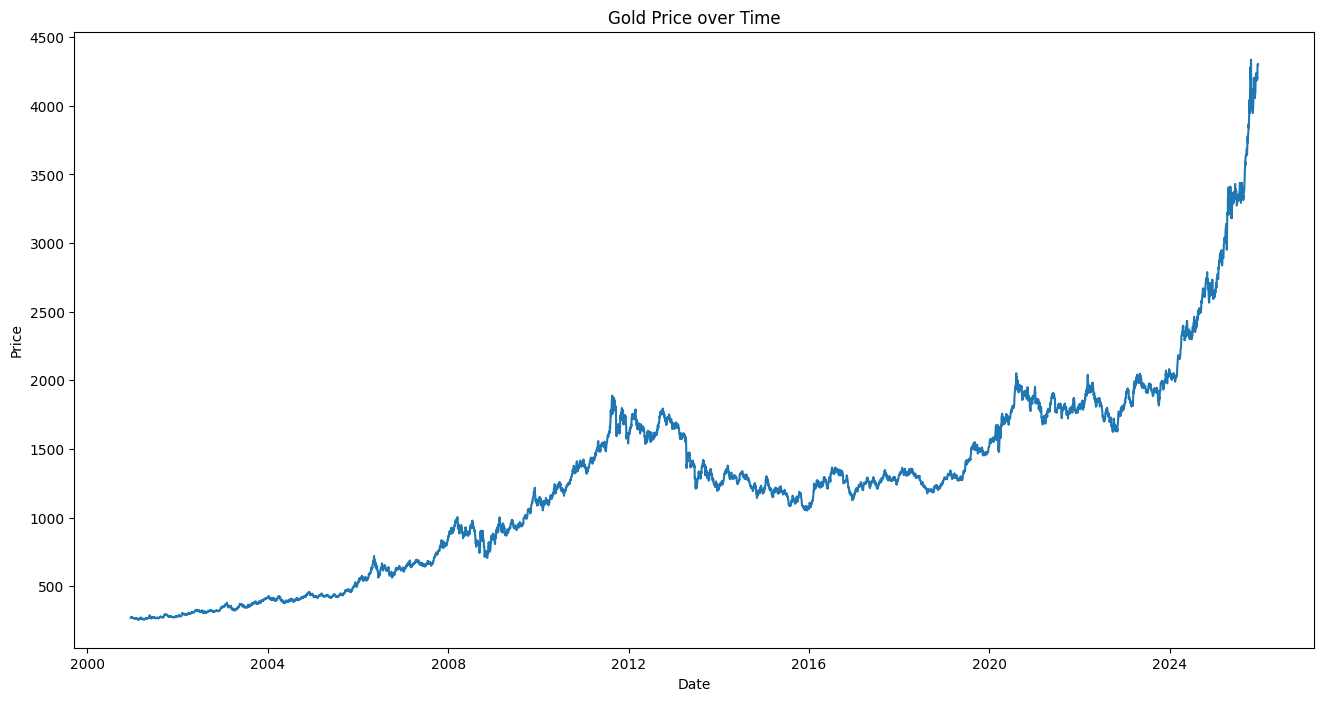

In [10]:
# visualization of closing value over time
plt.figure(figsize=(16,8))
plt.plot(df['Date'],df['Close'])
plt.title("Gold Price over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

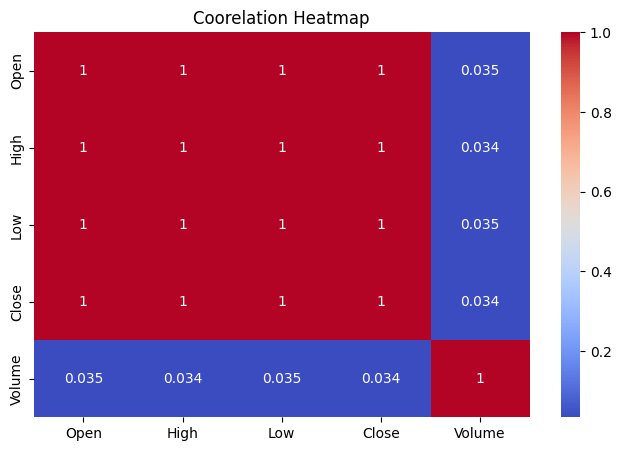

In [11]:
# correlation heatmap

plt.figure(figsize=(8,5))
sns.heatmap(df[["Open","High","Low","Close","Volume"]].corr(),annot=True,cmap = "coolwarm")
plt.title("Coorelation Heatmap")
plt.show()

In [12]:
df.dtypes

,0
Date,datetime64[ns]
Close,float64
High,float64
Low,float64
Open,float64
Volume,int64


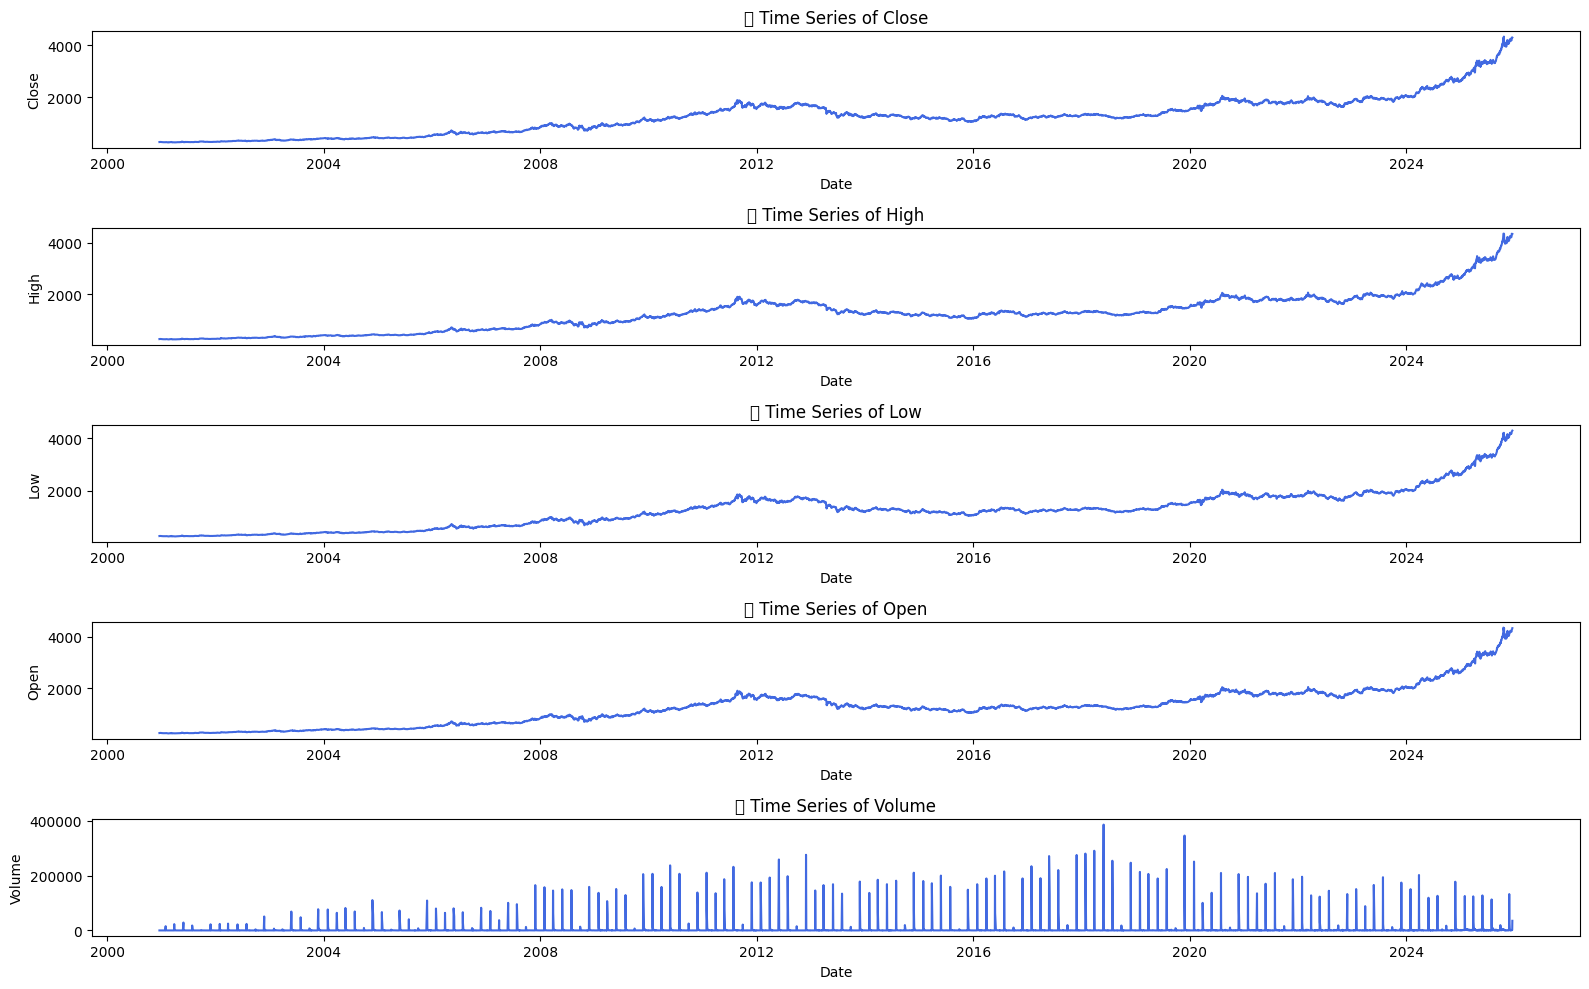

In [13]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
# Plot lineplots
plt.figure(figsize=(16, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.lineplot(x=df["Date"], y=df[col], linewidth=1.5, color="royalblue")
    plt.title(f"📈 Time Series of {col}", fontsize=12)
    plt.xlabel("Date")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [14]:
# Feature Engineering
feature_df = df.copy()

# daily return
df["Return"] = df["Close"].pct_change()

# Simple Moving Average(SMA)
df["SMA_7"]  = df["Close"].rolling(7).mean()
df["SMA_14"] = df["Close"].rolling(14).mean()
df["SMA_30"] = df["Close"].rolling(30).mean()

# Exponential Moving Averages(EMA)
df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()

# MACD
df["MACD"] = df["EMA_12"] - df["EMA_26"]

# RST(14-day)
delta = df["Close"].diff()

gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))


# Lag Features
df["Lag_1"]  = df["Close"].shift(1)
df["Lag_7"]  = df["Close"].shift(7)
df["Lag_14"] = df["Close"].shift(14)

df.dropna(inplace=True)

df.head()





,Date,Close,High,Low,Open,Volume,Return,SMA_7,SMA_14,SMA_30,EMA_12,EMA_26,MACD,RSI,Lag_1,Lag_7,Lag_14
29,2001-01-31,265.600006,266.000000,263.700012,265.200012,566,0.000377,264.514282,264.349997,267.503335,264.916014,266.174734,-1.258720,53.913007,265.500000,266.399994,264.700012
30,2001-02-01,268.500000,268.899994,266.299988,266.299988,410,0.010919,264.857139,264.671426,267.463334,265.467396,266.346976,-0.879580,66.423343,265.600006,266.100006,264.000000
31,2001-02-02,267.100006,268.200012,266.500000,268.000000,107,-0.005214,265.257141,264.899998,267.376667,265.718567,266.402756,-0.684189,60.666707,268.500000,264.299988,263.899994
32,2001-02-05,265.200012,265.799988,265.100006,265.100006,192,-0.007113,265.357143,265.035714,267.133334,265.638789,266.313664,-0.674874,55.828300,267.100006,264.500000,263.299988
33,2001-02-06,263.299988,263.899994,261.799988,263.899994,25,-0.007164,265.428571,265.042855,266.786667,265.278974,266.090428,-0.811455,50.276175,265.200012,262.799988,263.200012


In [15]:
# Train-Test Split
train_df = feature_df[feature_df['Date'] <= '2020-12-31']
test_df = feature_df[feature_df['Date'] >= '2021-01-01']


X_train = train_df.drop(['Date', 'Close'], axis=1)
y_train = train_df['Close']


X_test = test_df.drop(['Date', 'Close'], axis=1)
y_test = test_df['Close']

In [16]:
# Data scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()


X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()

In [17]:
# SVR Model
svr_model = SVR(
    kernel='rbf',
    C=100,
    gamma=0.1,
    epsilon=0.01
)
svr_model.fit(X_train_scaled, y_train_scaled)

SVR(C=100, epsilon=0.01, gamma=0.1)

In [18]:
# Prediction
svr_pred_scaled = svr_model.predict(X_test_scaled)
# inverse scaling(actual price ma predict garos )
svr_pred = scaler_y.inverse_transform(svr_pred_scaled.reshape(-1,1)).ravel()

In [19]:
# Metrics Evaluation of SVR
svr_mae = mean_absolute_error(y_test, svr_pred)
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_pred))
svr_r2 = r2_score(y_test, svr_pred)


print("SVR Performance")
print("MAE :", svr_mae)
print("RMSE:", svr_rmse)
print("R2 :", svr_r2)

SVR Performance
MAE : 64.20603597547192
RMSE: 159.03379433835136
R2 : 0.9394062171803607


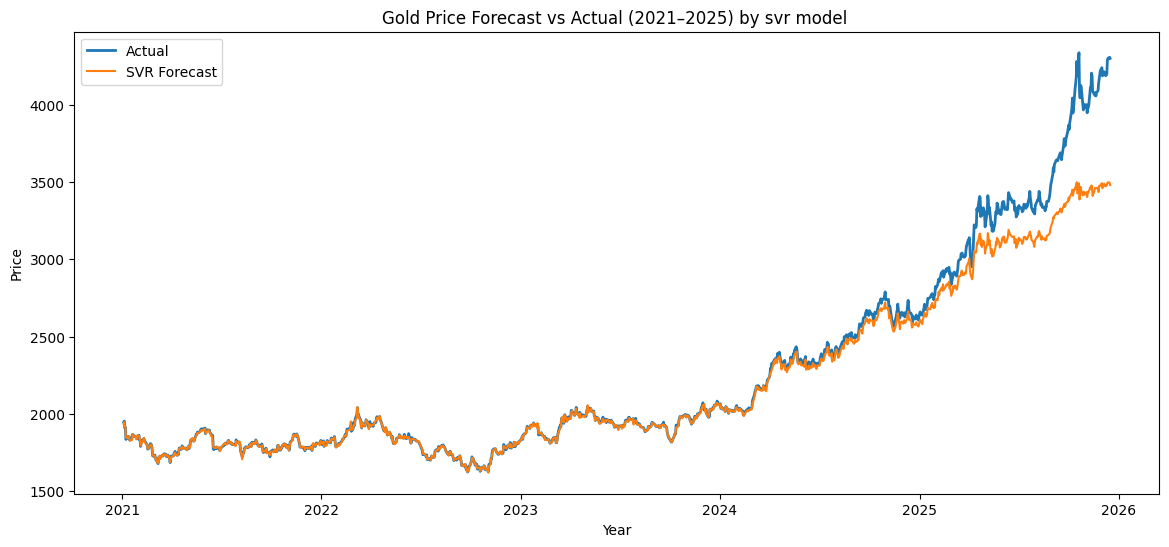

In [20]:
plt.figure(figsize=(14,6))
plt.plot(test_df['Date'], y_test.values, label='Actual', linewidth=2)
plt.plot(test_df['Date'], svr_pred, label='SVR Forecast')
plt.title('Gold Price Forecast vs Actual (2021–2025) by svr model ')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [21]:
# MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(64,32), activation='relu',
solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train_scaled)





MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

In [22]:
# Prediction
mlp_pred_scaled = mlp.predict(X_test_scaled)
# inverse scaling
mlp_pred = scaler_y.inverse_transform(mlp_pred_scaled.reshape(-1,1)).ravel()

In [23]:
# Evaluation Metrics of MLP
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_pred))
mlp_r2 = r2_score(y_test, mlp_pred)


print("MLP Performance")
print("MAE :", mlp_mae)
print("RMSE:", mlp_rmse)
print("R2 :", mlp_r2)

MLP Performance
MAE : 200.3427853247098
RMSE: 374.23469469965363
R2 : 0.6644653929166016


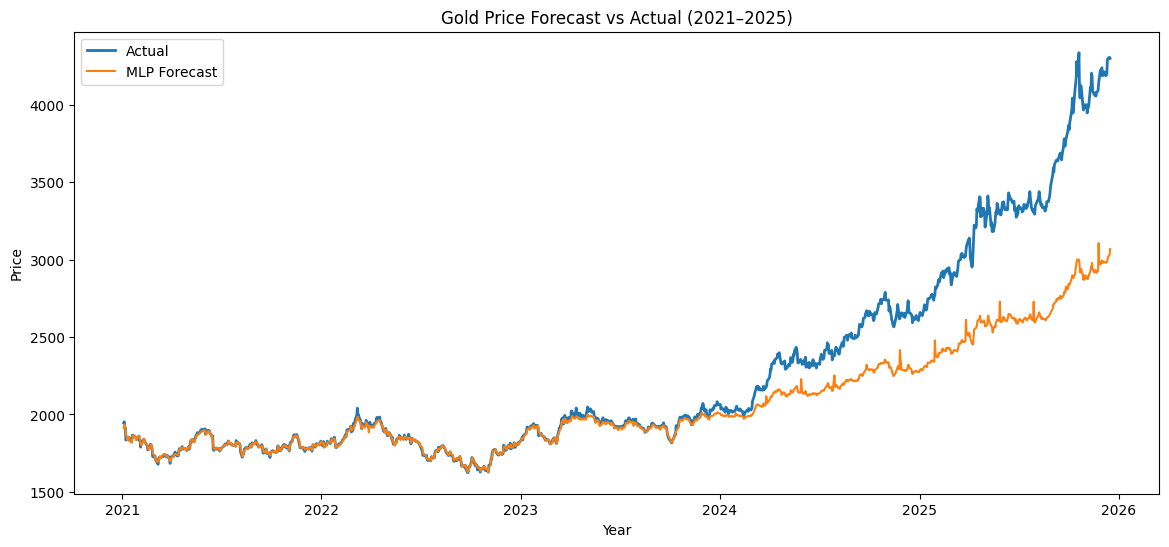

In [24]:
# Forecasting
plt.figure(figsize=(14,6))
plt.plot(test_df['Date'], y_test.values, label='Actual', linewidth=2)
plt.plot(test_df['Date'], mlp_pred, label='MLP Forecast')
plt.title('Gold Price Forecast vs Actual (2021–2025)')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
# saving forecast results
results = pd.DataFrame({
'Date': test_df['Date'],
'Actual': y_test.values,
'SVR_Prediction': svr_pred,
'MLP_Prediction': mlp_pred
})


results.to_csv('gold_forecast_comparison.csv', index=False)
results.head()

,Date,Actual,SVR_Prediction,MLP_Prediction
5026,2021-01-04,1944.699951,1932.626357,1916.195270
5027,2021-01-05,1952.699951,1947.211816,1935.001159
5028,2021-01-06,1906.900024,1914.578900,1924.553569
5029,2021-01-07,1912.300049,1915.663734,1912.577995
5030,2021-01-08,1834.099976,1847.432437,1874.759176


In [26]:
# Hyperparameter tuning for svr
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR

svr = SVR()

svr_param_dist = {
    "C": [0.1, 1, 10, 100, 500],
    "gamma": [0.001, 0.01, 0.1, 1],
    "epsilon": [0.001, 0.01, 0.1],
    "kernel": ["rbf"]
}

svr_random = RandomizedSearchCV(
    estimator=svr,
    param_distributions=svr_param_dist,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=3,
    random_state=42,
    n_jobs=-1
)

svr_random.fit(X_train_scaled, y_train_scaled)

best_svr = svr_random.best_estimator_

# Prediction
svr_pred_scaled = best_svr.predict(X_test_scaled)
svr_pred = scaler_y.inverse_transform(
    svr_pred_scaled.reshape(-1, 1)
).ravel()

print("Best SVR Params:", svr_random.best_params_)


Best SVR Params: {'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 0.001, 'C': 500}


In [27]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    max_iter=1000,
    early_stopping=True,
    random_state=42
)

mlp_param_dist = {
    "hidden_layer_sizes": [(64,), (128,), (64,32), (128,64)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "learning_rate_init": [0.0001, 0.001, 0.01],
    "alpha": [0.0001, 0.001, 0.01],
    "batch_size": [16, 32, 64]
}

mlp_random = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=mlp_param_dist,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=3,
    random_state=42,
    n_jobs=-1
)

mlp_random.fit(X_train_scaled, y_train_scaled)

best_mlp = mlp_random.best_estimator_

# Prediction
mlp_pred_scaled = best_mlp.predict(X_test_scaled)
mlp_pred = scaler_y.inverse_transform(
    mlp_pred_scaled.reshape(-1, 1)
).ravel()

print("Best MLP Params:", mlp_random.best_params_)


Best MLP Params: {'solver': 'adam', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (64, 32), 'batch_size': 64, 'alpha': 0.0001, 'activation': 'tanh'}


In [28]:
# after tuning performance metrices
svr_mae  = mean_absolute_error(y_test, svr_pred)
svr_mse  = mean_squared_error(y_test, svr_pred)
svr_rmse = np.sqrt(svr_mse)
svr_r2   = r2_score(y_test, svr_pred)

print("Mean Absolute Error :",svr_mae)
print("Mean Squared Error :",svr_mse)
print("Root Mean Squared Error :",svr_rmse)
print("R^2 score :",svr_r2)

Mean Absolute Error : 48.1648867529371
Mean Squared Error : 17240.36825844755
Root Mean Squared Error : 131.3025828323554
R^2 score : 0.9586956528013079


In [29]:
# after tuning performance metrices
mlp_mae  = mean_absolute_error(y_test, mlp_pred)
mlp_mse  = mean_squared_error(y_test, mlp_pred)
mlp_rmse = np.sqrt(mlp_mse)
mlp_r2   = r2_score(y_test, mlp_pred)

print("Mean Absolute Error :",mlp_mae)
print("Mean Squared Error :",mlp_mse)
print("Root Mean Squared Error :",mlp_rmse)
print("R^2 score :",mlp_r2)

Mean Absolute Error : 68.40970762148437
Mean Squared Error : 19040.065707084905
Root Mean Squared Error : 137.98574457923146
R^2 score : 0.9543839509190296


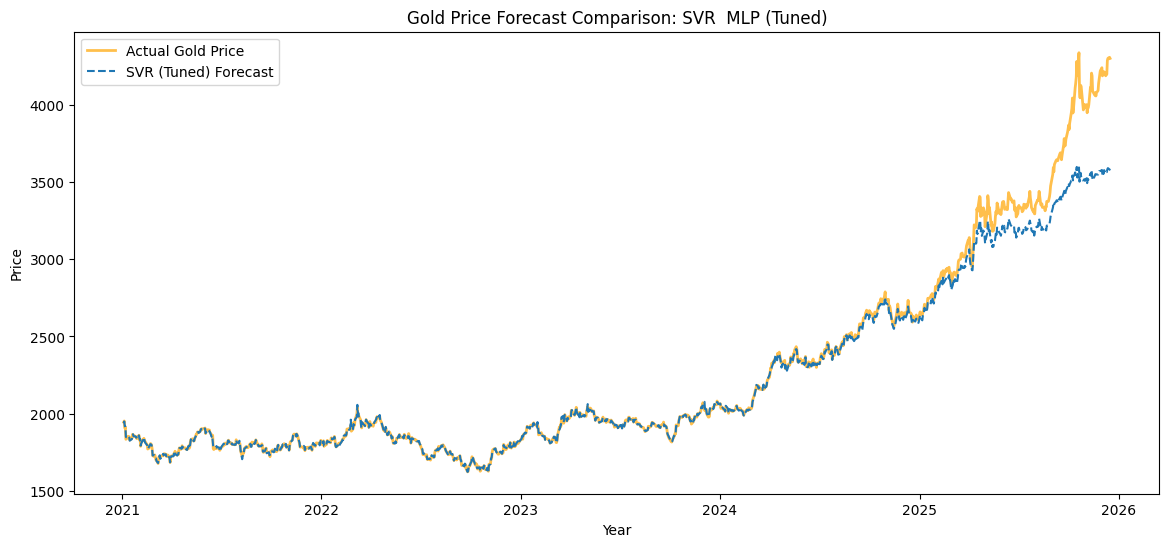

In [30]:
# Final visualization after tuning

plt.figure(figsize=(14, 6))

# Plotting the Actual values
plt.plot(test_df['Date'], y_test.values, label='Actual Gold Price', linewidth=2, color='orange', alpha=0.7)

# Plotting the Tuned SVR Predictions
plt.plot(test_df['Date'], svr_pred, label='SVR (Tuned) Forecast', linestyle='--')

plt.title('Gold Price Forecast Comparison: SVR  MLP (Tuned)')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()

plt.show()

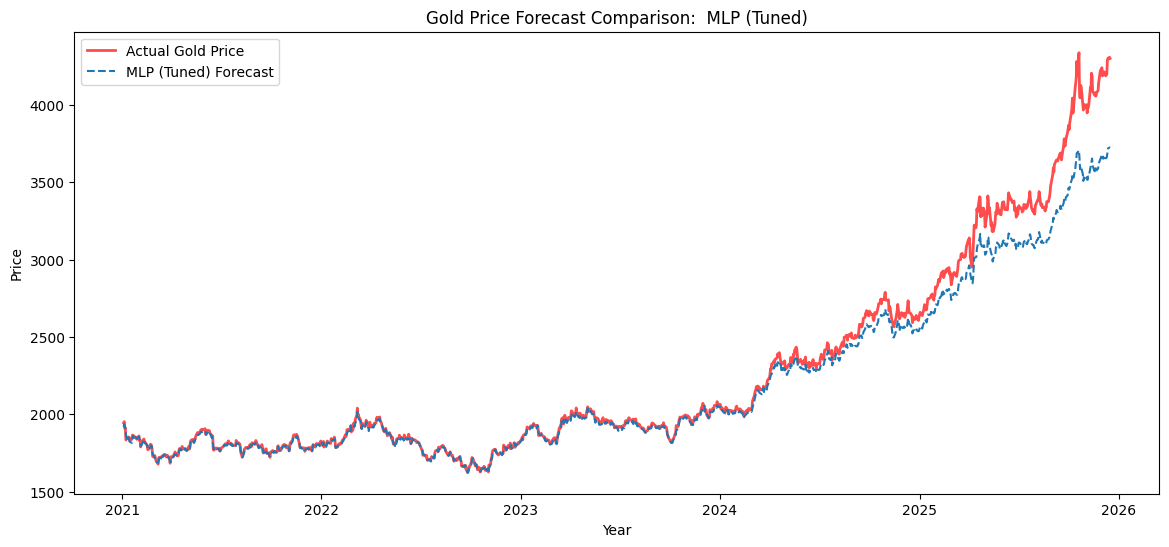

In [31]:
# ================================
# Final Visualization (After Tuning)
# ================================

plt.figure(figsize=(14, 6))

# Plotting the Actual values
plt.plot(test_df['Date'], y_test.values, label='Actual Gold Price', linewidth=2, color='red', alpha=0.7)

# Plotting the Tuned MLP Predictions
plt.plot(test_df['Date'], mlp_pred, label='MLP (Tuned) Forecast', linestyle='--')

plt.title('Gold Price Forecast Comparison:  MLP (Tuned)')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()

plt.show()

In [32]:
feature_cols = [
    "Return",
    "SMA_7", "SMA_14", "SMA_30",
    "EMA_12", "EMA_26",
    "MACD",
    "RSI",
    "Lag_1", "Lag_7", "Lag_14"
]


In [33]:
X = df[feature_cols]

X_train = X[df["Date"] <= "2020-12-31"]
X_test  = X[df["Date"] >= "2021-01-01"]

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)


In [43]:
target = "Close"


In [44]:
from sklearn.ensemble import VotingRegressor

y_train = df.loc[X_train.index, target]

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(
    y_train.values.reshape(-1, 1)
).ravel()


svr = SVR(
    kernel="rbf",
    C=best_svr.get_params()["C"],
    gamma=best_svr.get_params()["gamma"],
    epsilon=best_svr.get_params()["epsilon"]
)

mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    max_iter=1000,
    early_stopping=True,
    random_state=42
)


close_model = VotingRegressor(
    estimators=[
        ("svr", svr),
        ("mlp", mlp)
    ]
)

close_model.fit(X_train_scaled, y_train_scaled)

VotingRegressor(estimators=[('svr', SVR(C=500, epsilon=0.001, gamma=0.1)),
                            ('mlp',
                             MLPRegressor(early_stopping=True,
                                          hidden_layer_sizes=(128, 64),
                                          learning_rate='adaptive',
                                          max_iter=1000, random_state=42))])

In [45]:
# Predict Next-Day Close

latest_features = df.iloc[-1:][feature_cols]
X_latest_scaled = scaler_X.transform(latest_features)


pred_close_scaled = close_model.predict(X_latest_scaled)

pred_close = scaler_y.inverse_transform(
    pred_close_scaled.reshape(-1, 1)
)[0, 0]

pred_close



# Buy/Sell Decision
current_close = df["Close"].iloc[-1]

price_change_pct = (pred_close - current_close) / current_close * 100

if price_change_pct > 0.3:
    signal = "BUY"
elif price_change_pct < -0.3:
    signal = "SELL"
else:
    signal = "HOLD"

signal




'SELL'

In [46]:
print("NEXT DAY GOLD FORECAST (CLOSE ONLY)")
print("----------------------------------")
print(f"Predicted Close : {pred_close:.2f}")
print(f"Current Close   : {current_close:.2f}")
print(f"Change (%)      : {price_change_pct:.2f}%")
print("TRADE SIGNAL    :", signal)


NEXT DAY GOLD FORECAST (CLOSE ONLY)
----------------------------------
Predicted Close : 3257.97
Current Close   : 4299.60
Change (%)      : -24.23%
TRADE SIGNAL    : SELL
